## Import libraries, methods and constants

In [1]:
import numpy as np
import json
import torch
import cv2
import matplotlib.pyplot as plt
from transformers import AutoModelForSemanticSegmentation
import os
from os import sys

c:\Users\kuian\.conda\envs\master\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
from config import model_types, crops
from constants import weed_plants, weed_plants, annotation_folder
from data_prepossessing import create_datasets_for_plants, get_labels

## Check if GPU is detected

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # use GPU if available, otherwise use a CPU
print(device)

cpu


## Analyze training and evaluation runtimes, the number of epochs and training and validation losses

In [4]:
def preprocess_model_performance_info_for_model(model_folder):
    train_runtimes = {}
    eval_runtimes = {}
    epochs = {}
    total_train_loss = {}
    train_losses = {}
    eval_losses = {}

    for model_type in model_types:
        train_runtimes[model_type] = {}
        eval_runtimes[model_type] = {}
        epochs[model_type] = {}
        total_train_loss[model_type] = {}
        train_losses[model_type] = {}
        eval_losses[model_type] = {}

        for crop in crops:
            with open('../' + model_folder + '/' + model_type + '/' + crop + '/log_history.json', 'r') as file:
                data = json.load(file)
                
                train_runtimes[model_type][crop] = data[-1]['train_runtime']
                epochs[model_type][crop] = data[-1]['epoch']

                eval_runtimes[model_type][crop] = []
                train_losses[model_type][crop] = []
                eval_losses[model_type][crop] = []
                for entry in data:
                    if 'eval_runtime' in entry.keys():
                        eval_runtimes[model_type][crop].append(entry['eval_runtime'])

                    if 'eval_loss' in entry.keys():
                        eval_losses[model_type][crop].append(entry['eval_loss'])

                    if 'loss' in entry.keys():
                        train_losses[model_type][crop].append(entry['loss'])

                    if 'train_loss' in entry.keys():
                        total_train_loss[model_type][crop] = entry['train_loss']

    return train_runtimes, eval_runtimes, epochs, total_train_loss, train_losses, eval_losses

In [5]:
def plot_bar_chart(data, title):
    # Extract the labels and values for the 'binary' and 'multiclass' categories
    crops = list(data['binary'].keys())
    binary_values = [data['binary'][crop] for crop in crops]
    multiclass_values = [data['multiclass'][crop] for crop in crops]

    # Set the width of the bars
    bar_width = 0.35
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create bar positions for each category
    x = range(len(crops))

    # Plot the 'binary' values
    plt.bar(x, binary_values, width=bar_width, label='Binary', align='center')

    # Plot the 'multiclass' values with an offset
    plt.bar([i + bar_width for i in x], multiclass_values, width=bar_width, label='Multiclass', align='center')

    plt.title(title)
    crop_labels = [crop.replace("_", " ") for crop in crops]
    plt.xticks([i + bar_width / 2 for i in x], crop_labels, rotation=45)

    plt.legend()
    plt.tight_layout()
    plt.show()

In [6]:
def plot_heat_map(data, title):
    categories = list(data.keys())

    # Convert the data to a NumPy array
    heatmap_data = np.array([[data[category][crop] for crop in crops] for category in categories])

    fig, ax = plt.subplots(figsize=(10, 6))
    # Create the heatmap
    cax = ax.matshow(heatmap_data, cmap='viridis')

    # Add colorbar
    cbar = fig.colorbar(cax)

    # Set labels for the x and y axes
    labels = [crop.replace("_", " ") for crop in list(data['binary'].keys())]
    
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(categories)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(categories)

    # Show the values in each cell
    # for i in range(len(categories)):
    #     for j in range(len(items)):
    #         text = ax.text(j, i, f'{heatmap_data[i, j]:.2f}', ha='center', va='center', color='w', fontsize=8)  # Specify fontsize
    plt.title('Heatmap of Values for Different Categories and Items')
    plt.tight_layout()
    plt.show()

In [7]:
def compute_general_numeric_statistics(train_runtimes, eval_runtimes, epochs, train_losses, eval_losses):
    train_runtime_total = 0
    eval_runtime_total = 0

    train_runtime_per_model_type = {}
    eval_runtime_per_model_type = {}

    for model_type in model_types:
        train_runtime_per_model_type[model_type] = 0
        eval_runtime_per_model_type[model_type] = 0

        for crop in crops:
            train_runtime_total = train_runtime_total + train_runtimes[model_type][crop]
            eval_runtime_total = eval_runtime_total + sum(eval_runtimes[model_type][crop])

            train_runtime_per_model_type[model_type] = train_runtime_per_model_type[model_type] + train_runtimes[model_type][crop]
            eval_runtime_per_model_type[model_type] = eval_runtime_per_model_type[model_type] + sum(eval_runtimes[model_type][crop])
        
    print('Total training time in h: ' + str(train_runtime_total/60/60))
    print('Total evaluation time in h: ' + str(eval_runtime_total/60/60))

    print('Training time for binary models : ' + str(train_runtime_per_model_type['binary']/60/60))
    print('Training time for multiclass models : ' + str(train_runtime_per_model_type['multiclass']/60/60))
    print('Evaluation time for binary models : ' + str(eval_runtime_per_model_type['binary']/60/60))
    print('Evaluation time for multiclass models : ' + str(eval_runtime_per_model_type['multiclass']/60/60))

In [8]:
train_runtimes, eval_runtimes, epochs, total_train_loss, train_losses, eval_losses = preprocess_model_performance_info_for_model('segformer-models-5-patience')

In [9]:
compute_general_numeric_statistics(train_runtimes, eval_runtimes, epochs, train_losses, eval_losses)

Total training time in h: 32.822256249999995
Total evaluation time in h: 15.772956805555557
Training time for binary models : 16.15026772222222
Training time for multiclass models : 16.671988527777778
Evaluation time for binary models : 7.741233527777779
Evaluation time for multiclass models : 8.031723277777779


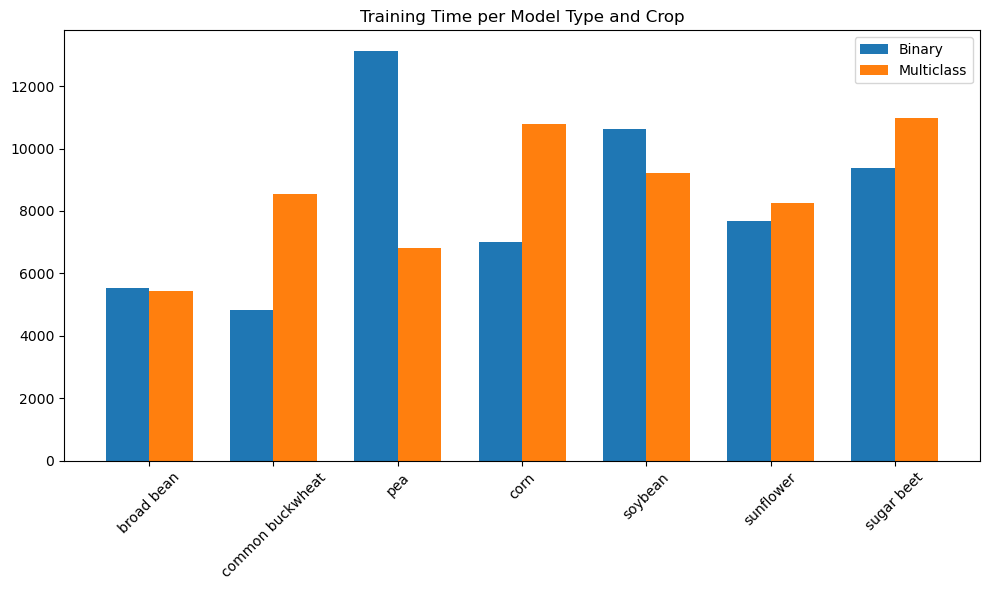

In [10]:
plot_bar_chart(train_runtimes, 'Training Time per Model Type and Crop')

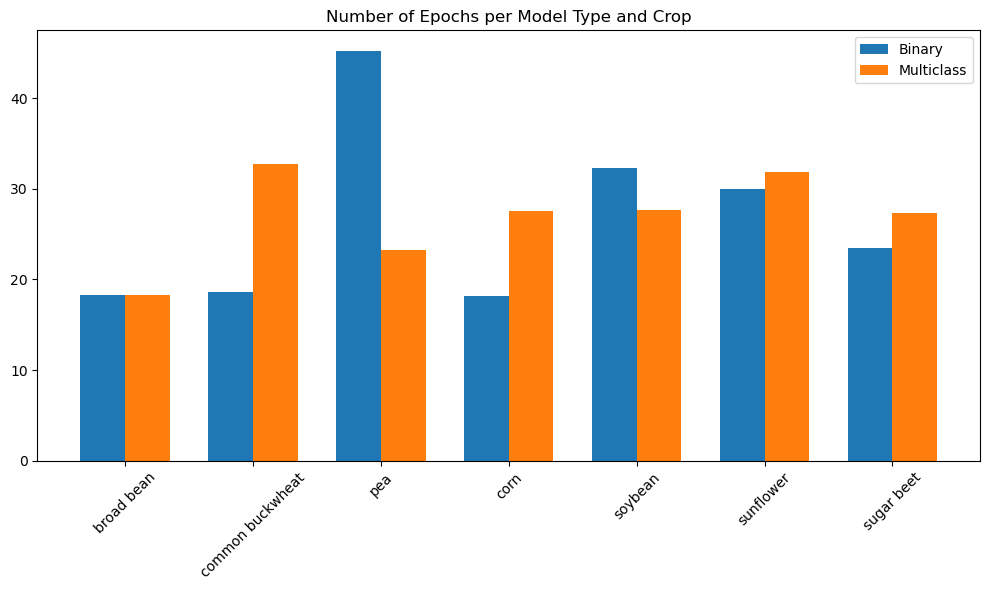

In [11]:
plot_bar_chart(epochs, 'Number of Epochs per Model Type and Crop')

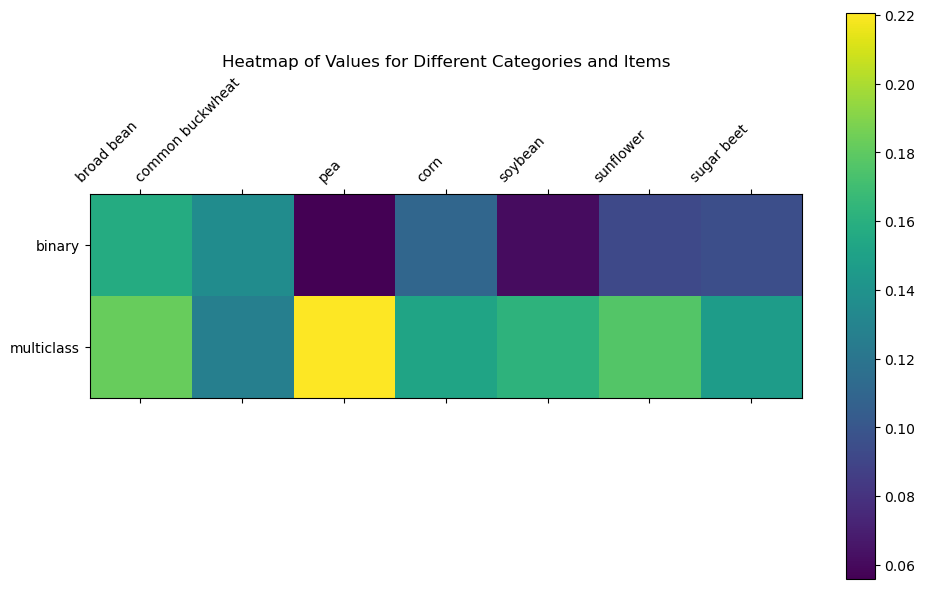

In [12]:
plot_heat_map(total_train_loss, 'Train Loss Heatmap per Model Type and Crop')

In [13]:
def plot_line_graph(data, title):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Loop through the categories and items to plot lines
    for category, item_data in data.items():
        for item, values in item_data.items():
            label = f'{category} - {item}'
            x = np.arange(len(values))
            ax.plot(x, values, label=label)

    ax.set_xlabel('Steps')
    ax.set_ylabel('Values')

    plt.title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()

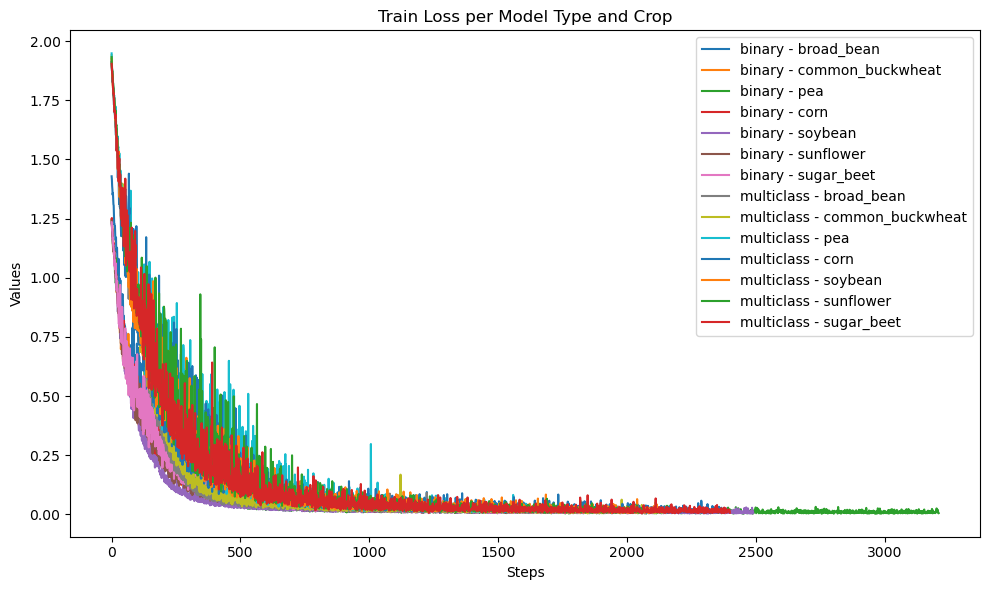

In [14]:
plot_line_graph(train_losses, 'Train Loss per Model Type and Crop')

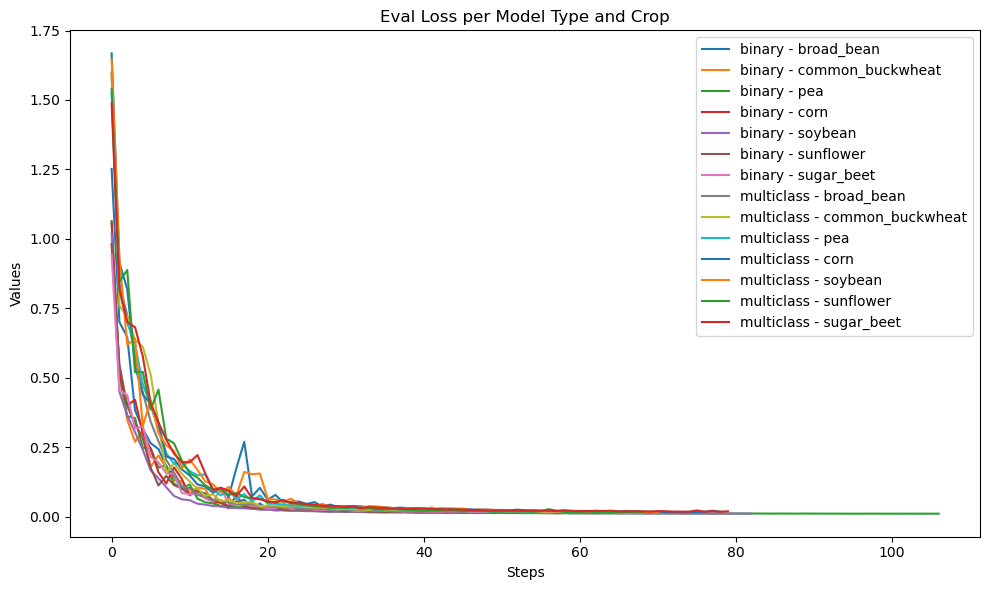

In [15]:
plot_line_graph(eval_losses, 'Eval Loss per Model Type and Crop')

## Predict test instances and build confusion matrix

In [16]:
segformer_checkpoint = "nvidia/mit-b0"
upernet_swin_checkpoint = "openmmlab/upernet-swin-tiny"

In [17]:
from transformers import AutoImageProcessor
segformer_image_processor = AutoImageProcessor.from_pretrained(segformer_checkpoint)
upernet_swin_image_processor = AutoImageProcessor.from_pretrained(upernet_swin_checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
c:\Users\kuian\.conda\envs\master\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [18]:
def get_test_data(crop, model_type):
    model_plant_names = [crop] + weed_plants
    train_ds, test_ds = create_datasets_for_plants(model_plant_names, model_type, crop)

    return test_ds

In [19]:
def get_model(crop, model_type, models_folder):
    id2label, label2id = get_labels(crop, model_type)

    checkpoint = models_folder + model_type + '/' + crop + '/'
    model = AutoModelForSemanticSegmentation.from_pretrained(checkpoint, id2label=id2label, label2id=label2id)
    model.to(device)

    return model

In [20]:
def pred_segm_mask(image, image_processor, device, model):
    encoding = image_processor(image, return_tensors="pt")
    pixel_values = encoding.pixel_values.to(device)

    outputs = model(pixel_values=pixel_values)

    logits = outputs.logits.cpu()

    upsampled_logits = torch.nn.functional.interpolate(
        logits,
        size=image.size[::-1],
        mode="bilinear",
        align_corners=False,
    )

    pred_seg = upsampled_logits.argmax(dim=1)[0]
    return pred_seg.detach().cpu().numpy()

In [21]:
def compute_predictions(image_processor, models_folder):
    for crop in crops:
        test_ds = get_test_data(crop, 'binary')

        for model_type in model_types:
            model = get_model(crop, model_type, ".." + models_folder)

            for test_ds_entry in test_ds:
                folder_path = "../predictions/" + models_folder + "/" + model_type + "/" + crop + "/"
                if not os.path.exists(folder_path):
                    os.makedirs(folder_path)

                if not os.path.isfile(folder_path):
                    pred_seg = pred_segm_mask(test_ds_entry["image"], image_processor, device, model)
                    cv2.imwrite(folder_path + test_ds_entry["image_name"], pred_seg)

In [22]:
compute_predictions(segformer_image_processor, '/segformer-models-3-patience/')

In [23]:
def use_one_channel(im):
    return im[:, :, 0]

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

prediction_masks = []
groud_truth_masks = []

# iterate over test data
for model_type in model_types:
    for crop in crops:
        test_ds = get_test_data(crop, model_type)

        for test_ds_entry in test_ds:
            y_pred = use_one_channel(cv2.imread("../predictions/segformer-models-3-patience/" + model_type + "/" + crop + "/" + test_ds_entry["image_name"])).flatten()
            y_true = use_one_channel(cv2.imread("../WE3DS/annotations_binary/" + crop + "/" + test_ds_entry["image_name"])).flatten()

            prediction_masks.extend(use_one_channel(y_pred)) # Save Prediction
            groud_truth_masks.extend(use_one_channel(y_true)) # Save Truth

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress')

# Build confusion matrix
cf_matrix = confusion_matrix(groud_truth_masks, prediction_masks)

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

In [ ]:
cf_matrix

array([[      0,       0,       0,       0],
       [      9, 1812697,     555,       0],
       [      3,    1983,   15151,       2],
       [      0,       0,       0,       0]], dtype=int64)